In [1]:
# Ml package Inports
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from torchvision.datasets import ImageNet
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset

In [2]:
# Helper package Imports
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import glob
from PIL import Image, ImageOps
from pathlib import Path
import splitfolders
import time
from tqdm.notebook import tqdm, trange
%matplotlib inline

In [3]:
# Extracting Dataset and renameing folder
if not Path("./Data/").is_dir() :
    with ZipFile('archive_5.zip',"r") as z:
        z.extractall(path="./Data/")
    old_name = str(os.listdir('./Data/')[0])
    os.renames('./Data/'+old_name, './Data/'+'Input')

In [4]:
# data directories
input_dir = './Data/Input/'
# output_dir = './Data/Output/'
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)

In [5]:
# filename check
imgs = os.listdir(input_dir)
print(f'Total Images : {len(imgs)}')
print(f'Sample Image Name : {imgs[5]}')

Total Images : 10511
Sample Image Name : 000000010218.jpg


In [6]:
# # change images
# if os.path.exists(output_dir):
#     for i in trange(len(imgs)):
#         imgName = imgs[i]
#         img = Image.open(input_dir+imgName)
#         img = img.convert('LA')
#         img.save(output_dir+f'{imgName.replace('.jpg','')}'+imgName.replace('.jpg', '.png'))
# os.listdir('./Data/Input/')

In [7]:
# transformer
img_transform = transforms.Compose([
    transforms.RandomCrop(250),
    transforms.ToTensor(),])

In [8]:
# for imgPath in [f'{input_dir}{img}' for img in os.listdir(input_dir)]:
#     img = Image.open(imgPath)
#     img = img_transform(img)
#     if img.shape != torch.Size([3, 250, 250]):
#         os.remove(imgPath)
# ?ToTensor

In [9]:
# create dataset
class DatasetBNW(Dataset):
    def __init__(self, path=input_dir, transform=None):
        self.data = [f'{path}{img}' for img in os.listdir(path)]
        self.transform = transform

    def __getitem__(self, index):
        target_img = Image.open(self.data[index])
        grey_img = ImageOps.grayscale(target_img)
        
        if self.transform is not None:
            target_img = self.transform(target_img)
            grey_img = self.transform(grey_img)
        return grey_img, target_img

    def __len__(self):
        return len(self.data)

In [10]:
# change one image
# img = Image.open(data_dir+imgs[0]).convert('LA')
# img.save(imgs[0].replace('.jpg', '.png'))
# img

In [11]:
# split data into train, validation and test data
def split_indices(n, val_pct, test_pct, seed=99):
    # determine the size of the validation set, test set
    n_val = int(val_pct*n)
    n_test = int(test_pct*n + n_val)
    # print(n_val, n_test, n_train)
    # create random parmutation of 0 to n-1
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    # pick data as train[start-val], validation[val-test] and test[test-end]
    return idxs[n_test:], idxs[:n_val], idxs[n_val:n_test]

In [12]:
# ?ImageFolder.make_dataset

In [13]:
# DataSet
dataset = DatasetBNW(path = './Data/Input/', transform = img_transform)

torch.Size([1, 250, 250])
tensor([[[0.1686, 0.2745, 0.2431,  ..., 0.4510, 0.4784, 0.4588],
         [0.1686, 0.1412, 0.2000,  ..., 0.4549, 0.4392, 0.4392],
         [0.0627, 0.0588, 0.0824,  ..., 0.4627, 0.4863, 0.4157],
         ...,
         [0.9373, 0.9451, 0.9451,  ..., 0.9255, 0.9412, 0.9216],
         [0.9373, 0.9412, 0.9412,  ..., 0.9373, 0.9294, 0.9294],
         [0.9373, 0.9412, 0.9412,  ..., 0.9216, 0.9333, 0.9490]]])


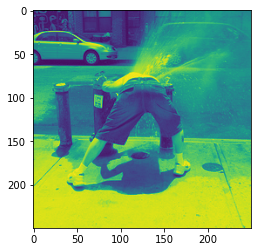

In [14]:
x = dataset[500][0]
plt.imshow(x.to('cpu').permute(1,2,0).detach().numpy())
# x.shape
print(x.shape)
print(x)

In [15]:
# dataset = []
# for i in trange(len(datasetfull)):
#     grey, target = datasetfull[i]
#     if grey.shape == torch.Size([1, 250, 250]) and target.shape == torch.Size([3, 250, 250]):
#         dataset.append(datasetfull[i])
#     else:
#         print(f"found 1 at {i+1}")
# # # target

In [16]:
# split the dataset into training, validation and test set
train_indices, val_indices, test_indices = split_indices(len(dataset), 0.2, 0.1)
print(f"""
        Training Images   : {len(train_indices)}\n
        Validation Images : {len(val_indices)}\n
        Testing Images    : {len(test_indices)}\n
        Total Images      : {len(train_indices) + len(val_indices) + len(test_indices)}""")


        Training Images   : 7358

        Validation Images : 2102

        Testing Images    : 1051

        Total Images      : 10511


In [17]:
# hyper parameter
batch_size=25
learning_rate = pow(10,-4)

In [18]:
# training sampler and dataloader
train_sampler = SubsetRandomSampler(train_indices)    # takes samples w.r.t the indices
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler = train_sampler)


In [19]:
# for i, t in train_dl:
#     print(i.shape)
#     break

In [20]:
# validation sampler and dataloader
val_sampler = SubsetRandomSampler(val_indices)        # takes samples w.r.t the indices
val_dl = DataLoader(dataset,
                    batch_size,
                    sampler = val_sampler)

In [21]:
# test sampler and dataloader
test_sampler = SubsetRandomSampler(test_indices)        # takes samples w.r.t the indices
test_dl = DataLoader(dataset,
                     batch_size,
                     sampler = test_sampler)

In [22]:
input_size = 1*250*250   #input is a image of dimention [1, 250, 250]
target_size = 3*250*250  #target is a image of dimention [3, 250, 250]

In [23]:
# Accuracy function
def accuracy(l1, l2):
    return torch.sum(l1 == l2).item() / len(l1)

In [24]:
# # get device function
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [25]:
# set device
device = get_device()

In [26]:
def calMaxpool(i, k, s):
    return int((i-(k-1))/s)

print(calMaxpool(20, 2, 2))

9


# ColorizationConvModel

In [73]:
# model
class ColorizationConvModel(nn.Module):
    def __init__(self):
        super(ColorizationConvModel, self).__init__()
        self.L1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),                    
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),                                           # bs * 16 * 126 * 126
            nn.Dropout2d(0.2),
        )
        
        self.L2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),                    
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),                                           # bs * 32 * 64 * 64
            nn.Dropout2d(0.2),
        )
        
        self.L3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),                    
            nn.ReLU(), 
            nn.AvgPool2d(2, stride=2),                                           # bs * 64 * 33 * 33
            nn.Dropout2d(0.2),
        )
        
        self.L4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),                   
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),                                           # bs * 128 * 17 * 17
            nn.Dropout2d(0.2),
        )
        
        self.L5 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),                    
            nn.Tanh(),
            nn.Upsample(size=(33, 33), mode='bilinear', align_corners=False),    # bs * 64 * 33 * 33
            nn.Dropout2d(0.2),
        )
        
        self.L6 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),                    
            nn.Tanh(),
            nn.Upsample(size=(64, 64), mode='bilinear', align_corners=False),    # bs * 32 * 64 * 64
            nn.Dropout2d(0.2),
        )
        
        self.L7 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),                    
            nn.Tanh(),
            nn.Upsample(size=(126, 126), mode='bilinear', align_corners=False),  # bs * 16 * 126 * 126
            nn.Dropout2d(0.2),
        )
        
        self.L8R = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(1),                    
            nn.Tanh(),
            nn.Upsample(size=(250, 250), mode='bilinear', align_corners=False),  # bs * 1 * 250 * 250
        )
        
        self.L8G = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(1),                    
            nn.Tanh(),
            nn.Upsample(size=(250, 250), mode='bilinear', align_corners=False),  # bs * 1 * 250 * 250
        )
        
        self.L8B = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(1),                    
            nn.Tanh(),
            nn.Upsample(size=(250, 250), mode='bilinear', align_corners=False),  # bs * 1 * 250 * 250
        )
        
#         self.sig = nn.Sequential(
#             nn.Sigmoid()
#         )
        
        
    def forward(self, x):
#         print(f'Shape At Input layer : {x.size()}')
        
        out = self.L1(x)
#         print(f'Shape After 1st layer: {out.size()}')
        
        out = self.L2(out)
#         print(f'Shape After 2nd layer: {out.size()}')
        
        out = self.L3(out)
#         print(f'Shape After 3rd layer: {out.size()}')
        
        out = self.L4(out)
#         print(f'Shape After 4rt layer: {out.size()}')
        
        out = self.L5(out)
#         print(f'Shape After 5th layer: {out.size()}')
        
        out = self.L6(out)
#         print(f'Shape After 6th layer: {out.size()}')
        
        out = self.L7(out)
#         print(f'Shape After 7th layer: {out.size()}')
        
        outR = self.L8R(out)
        outG = self.L8G(out)
        outB = self.L8B(out)
        
        outR = outR.add(x)
        outG = outG.add(x)
        outB = outB.add(x)
        
#         outR = nn.Sigmoid(outR)
#         outG = nn.Sigmoid(outG)
#         outB = nn.Sigmoid(outB)
        
#         outR = torch.div(outR, 2)
#         outG = torch.div(outG, 2)
#         outB = torch.div(outB, 2)
        
        out = torch.cat((outR, outG, outB), 1)

        return out

In [74]:
# ?plt.subplot2grid

In [75]:
# model
model = ColorizationConvModel().to(device)

In [76]:
# ?torch.div
# ax = plt.subplot2grid((1, 2), (row, col), 1, 1)

In [77]:
for data in train_dl:
    grey, _ = data
    out = model(grey.to(device))
    print(f'output shape: {out.size()}')
#     print(grey)
    break

output shape: torch.Size([25, 3, 250, 250])


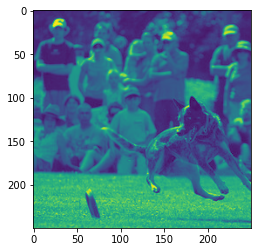

In [78]:
# sample input
plt.imshow(grey[0].to('cpu').permute(1,2,0).detach().numpy())

In [79]:
grey[0]

tensor([[[0.1059, 0.1176, 0.1255,  ..., 0.1137, 0.1176, 0.1255],
         [0.1098, 0.1216, 0.1255,  ..., 0.1137, 0.1176, 0.1255],
         [0.1137, 0.1255, 0.1255,  ..., 0.1137, 0.1137, 0.1176],
         ...,
         [0.6392, 0.6745, 0.6784,  ..., 0.5373, 0.6196, 0.5804],
         [0.6510, 0.6980, 0.6706,  ..., 0.6431, 0.6392, 0.5451],
         [0.6549, 0.7059, 0.6667,  ..., 0.6784, 0.6392, 0.5686]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


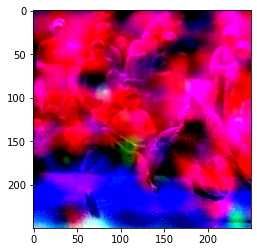

In [80]:
# sample output
plt.imshow(out[0].to('cpu').permute(1,2,0).detach().numpy())

In [81]:
out[0]

tensor([[[ 0.1291,  0.1373,  0.1378,  ...,  0.7948,  0.8088,  0.8216],
         [ 0.1419,  0.1501,  0.1469,  ...,  0.8032,  0.8169,  0.8295],
         [ 0.1639,  0.1722,  0.1652,  ...,  0.8203,  0.8294,  0.8378],
         ...,
         [ 0.3843,  0.4199,  0.4245,  ...,  0.0730,  0.1838,  0.1585],
         [ 0.4305,  0.4788,  0.4538,  ...,  0.2091,  0.2334,  0.1532],
         [ 0.4514,  0.5040,  0.4682,  ...,  0.2592,  0.2482,  0.1915]],

        [[-0.7638, -0.7538, -0.7495,  ..., -0.8395, -0.8347, -0.8264],
         [-0.7617, -0.7516, -0.7512,  ..., -0.8397, -0.8349, -0.8266],
         [-0.7615, -0.7513, -0.7544,  ..., -0.8400, -0.8392, -0.8349],
         ...,
         [ 0.7505,  0.7870,  0.7933,  ...,  0.2787,  0.3338,  0.2812],
         [ 0.7956,  0.8445,  0.8207,  ...,  0.4187,  0.3890,  0.2822],
         [ 0.8159,  0.8690,  0.8342,  ...,  0.4707,  0.4065,  0.3236]],

        [[ 0.3129,  0.3117,  0.2932,  ...,  0.0578,  0.0458,  0.0458],
         [ 0.3238,  0.3222,  0.2990,  ...,  0

In [82]:
# define criterion, optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
# model.parameters
torch.cuda.empty_cache()
# torch.cuda.

In [38]:
# # fig = plt.subplots(5, 5)
# for grey, target in train_dl:
#     pred = model(grey.to(device))
#     for i, a in enumerate(pred):
#         out = pred[i].to('cpu').permute(1,2,0).detach().numpy()
#         plt.imshow(out, interpolation='none')
#         break
#     break
# fig.show()
# # ?plt.subplot

In [39]:
# # write the trianing loop
# def train(model, optimizer, criterion, train_loader, num_epoch):
#     total_step  = len(train_loader)
#     for epoch in trange(num_epoch):
#         for i, (greys, targets) in enumerate(train_loader):
#             greys = greys.to(device)
#             targets = targets.to(device)
            
#             outputs = model(greys)
#             loss = criterion(outputs, targets)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             if (i + 1) % 100 == 0:
#                 print(f"EPOCH: {epoch+1}/{num_epoch}, STEP: {i+1}/{total_step}, LOSS: {loss.item()}")

In [40]:
# train(model, optimizer, loss_fn, train_dl, 10)

## Train Function

In [84]:
# loss of a batch
def loss_batch(model, loss_func, input_batch, target_batch, optimizer=None, metric=None):
    # calculate the loss
    preds = model(input_batch.to(device))
    loss = loss_func(preds, target_batch.to(device))
    
    if optimizer is not None:
        # compute gradients
        loss.backward()
        
        # update the parameters
        optimizer.step()
        
        # reset the gradients
        optimizer.zero_grad()
        
    metric_result = None
    if metric is not None:
        # compute the metric
        metric_result = metric(preds, target_batch.to(device))
    
    return loss.item(), len(input_batch), metric_result

## Evaluation Function

In [85]:
# evaluation function
def evaluate(model, loss_func, valid_dl, metric=None):
    with torch.no_grad():
        # pass each batch throgh the model
        results = [loss_batch(model, loss_func, input_batch, target_batch, metric = metric)
                 for input_batch, target_batch in valid_dl]
        
        # seperate losses, counts and matrices
        losses, nums, metrices = zip(*results)
        
        # total size of the dataset
        total = np.sum(nums)
        
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        
        if metric is not None:
            # Avg. metric accross batches
            avg_metric = np.sum(np.multiply(metrices, nums)) / total
            
    return avg_loss, total, avg_metric

## Accuracy Function

In [87]:
def accuracy(outputs, targets):
    total_acc = 0
    for i in range(len(outputs)):
        diff = torch.sub(outputs[i], targets[i])
        diff = torch.abs(diff)
        ct = torch.sum(diff < 0.001).item()
        cs = np.prod(diff.shape)
        apc = ct / cs
        total_acc += apc
    return total_acc / len(outputs)

In [88]:
# accuracy(dataset[50][1], dataset[55][1])

## Validation Check

In [89]:
# check validation function
val_loss, total, val_acc = evaluate(model, loss_fn, val_dl, metric = accuracy)
print(f'Loss : {val_loss:.4f}, Total : {total:.4f}, Accuracy : {val_acc:.4f}')

Loss : 0.5890, Total : 2102.0000, Accuracy : 0.0008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


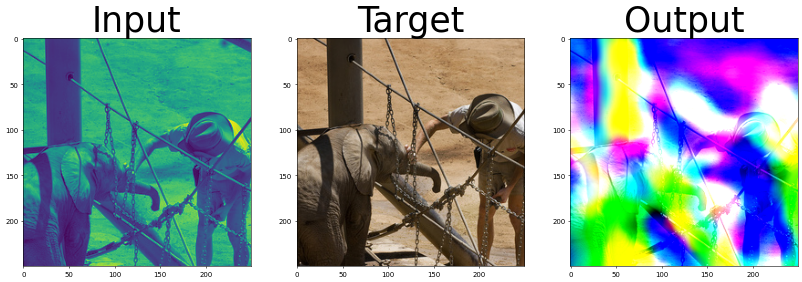

In [90]:
testResult(model, test_dl)

In [91]:
accuracies = [0]
losses = [0]

## Fit Function

In [92]:
def fit(epochs, model, loss_func, optimizer, train_dl, val_dl, metric=None):
    for epoch in trange(epochs):
        # training
        for input_batch, target_batch in train_dl:
            loss, _, _ = loss_batch(model, loss_func, input_batch, target_batch, optimizer)
        
        #evaluation
        result = evaluate(model, loss_func, val_dl, metric)
        val_loss, total, val_metric = result
        
        # print progress
        if metric is None:
            print(f"Epoch : [{epoch+1}/{epochs}], Loss : {val_loss:.4f}")
        else:
            accuracies.append(val_metric)
            losses.append(val_loss)
            print(f"Epoch : [{epoch+1}/{epochs}], Loss : {val_loss:.4f}, {metric.__name__} : {val_metric:.4f}")

## Comparing Result

In [93]:
def testResult(t_model, t_dl):
    for data in t_dl:
        grey, target = data
        out = t_model(grey.to(device))
        break
    
    plt.figure(figsize=(20,20), dpi=50)
    # target
    plt.subplot(1,3,1)
    plt.title('Input', fontdict = {'fontsize': 50})
    plt.imshow(grey[0].to('cpu').permute(1,2,0).detach().numpy())
    
    # target
    plt.subplot(1,3,2)
    plt.title('Target', fontdict = {'fontsize': 50})
    plt.imshow(target[0].to('cpu').permute(1,2,0).detach().numpy())
    
    # output
    plt.subplot(1,3,3)
    plt.title('Output', fontdict = {'fontsize': 50})
    plt.imshow(out[0].to('cpu').permute(1,2,0).detach().numpy())

## Reinitializing ColorizationConvModel

In [95]:
# Redefine model, optimizer and learning rate
model = ColorizationConvModel().to(device)
loss_fn = nn.MSELoss()
learning_rate = pow(10, -2)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training Starts

In [ ]:
fit(10, model, loss_fn, optimizer, train_dl, val_dl, accuracy)
testResult(model, test_dl)

Epoch : [1/10], Loss : 0.0636, accuracy : 0.0051
Epoch : [2/10], Loss : 0.0627, accuracy : 0.0049
Epoch : [3/10], Loss : 0.0624, accuracy : 0.0050
Epoch : [4/10], Loss : 0.0621, accuracy : 0.0052


In [ ]:
fit(10, model, loss_fn, optimizer, train_dl, val_dl, accuracy)
testResult(model, test_dl)

In [ ]:
fit(10, model, loss_fn, optimizer, train_dl, val_dl, accuracy)
testResult(model, test_dl)

In [ ]:
fit(10, model, loss_fn, optimizer, train_dl, val_dl, accuracy)
testResult(model, test_dl)

In [ ]:
fit(10, model, loss_fn, optimizer, train_dl, val_dl, accuracy)
testResult(model, test_dl)

In [ ]:
fit(10, model, loss_fn, optimizer, train_dl, val_dl, accuracy)
testResult(model, test_dl)

In [ ]:
# graph the accuracy and loss
def graphAcc():
    plt.plot(accuracies, '-x')
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy and loss')
    plt.title('Accuracy and Loss vs No. of epochs')
    plt.legend({'Accuracy','Loss'})

In [ ]:
graphAcc()

In [ ]:
# testResult()